In [1]:
import Ipynb_importer
import os
import json
import time
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from model import getVGG
import matplotlib.pyplot as plt
%matplotlib inline

importing Jupyter notebook from model.ipynb


In [2]:
"""
定义超参数
"""
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
epoch_num = 50
lr = 0.0001
batch_size = 64
model = getVGG(num_classes=5, init_weights=True)
model = model.to(device)

save_path = './myVGG.pth'
best_val_acc = 0.0

"""
loss定义
"""
loss_func = nn.CrossEntropyLoss()
"""
optimizer定义
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
定义绘图参数
"""
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
epochs_list = []

In [3]:
"""
获取数据
"""

# 用Compose串联多个数据增强操作
data_transform = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # ToTensor()将shape为(H, W, C)的nump.ndarray或img转为shape为(C, H, W)的tensor，其将每一个数值归一化到[0,1]
        transforms.ToTensor(),
        # 标准化：再使用公式"(x-mean)/std"，将每个元素分布到(-1,1)
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
    ]),
    "val":transforms.Compose([
        transforms.Resize((224, 224)),# cannot 224, must (224, 224)
        transforms.ToTensor(),
        # 标准化：再使用公式"(x-mean)/std"，将每个元素分布到(-1,1)
        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
    ])
}

data_root = "./data"

# datasets.ImageFolder详解: https://www.freesion.com/article/2553216784/
train_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'train'), transform=data_transform['train'])
val_dataset = datasets.ImageFolder(root=os.path.join(data_root, 'val'), transform=data_transform['val'])

train_num = len(train_dataset)
val_num = len(val_dataset)

# class_to_idx详解://www.cnblogs.com/xixixing/p/12759849.html 
class_dict = train_dataset.class_to_idx # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
class_dict = dict((v, k) for k,v in class_dict.items())# {0:'daisy', 1:'dandelion', 2:'roses' 3:'sunflower' 4:'tulips'}

# write dict into json file
with open('class_indices.json', 'w') as json_file:
    json.dump(class_dict, json_file, indent=4)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [4]:
def val():
    global best_val_acc
    running_loss = 0
    correct = 0 #已经预测结束且预测正确的样本数，初始化为0
    total = 0 #已经预测结束的样本数，初始化为0
    
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = loss_func(outputs, labels)
            running_loss += loss.item()
            
            _,pred = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
            val_accu = correct / total
        
        if val_accu > best_val_acc:
            best_val_acc = val_accu
            torch.save(model.state_dict(), save_path)
        
        val_acc_list.append(val_accu)
        val_loss_list.append(running_loss / val_num)
        
        print(f"[Val Loss]:{running_loss / val_num:3f}\t[Val Accurary]:{(val_accu * 100):3f}%")

In [5]:
def train():
    running_loss = 0
    correct = 0 #已经预测结束且预测正确的样本数，初始化为0
    total = 0 #已经预测结束的样本数，初始化为0
    
    model.train()
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # 梯度清零
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward() #反馈
        optimizer.step() #更新参数
        
        
        _,pred = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()
        train_accu = correct / total
        
        running_loss += loss.item()
        
        # 打印日志
        rate = (batch_idx + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "*" * int((1 - rate) * 50)
        print("\r[Train Loss]:{:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
        
    train_acc_list.append(train_accu)
    train_loss_list.append(running_loss / len(train_dataset))
    

#     print(f"[Train Loss]:{running_loss / len(train_dataset):3f}\t[Train Accurary]:{(train_accu * 100):2f}%")

In [6]:
def showAcc():
    plt.figure()
    plt.plot(epochs_list,val_acc_list,color="red",label="val_acc")
    plt.plot(epochs_list,train_acc_list,color="green",label="train_acc")
    plt.xlabel("epochs")
    plt.ylabel("Acc")
    plt.title('Accurary:VGG in flowers')
    plt.xticks([i for i in range(0,len(epochs_list),20)])
    acc_gap=[i*0.2 for i in range(0,min(int(len(epochs_list)/2+1),6))]
    acc_gap.append(max(val_acc_list))
    acc_gap.append(max(train_acc_list))
    plt.yticks(acc_gap)
    plt.grid()
    plt.legend()
    plt.savefig("./data/AccOfVGG.jpg")
    return
def showLoss():
    plt.figure()
    plt.plot(epochs_list,val_loss_list,color="red",label="val_loss")
    plt.plot(epochs_list,train_loss_list,color="green",label="train_loss")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Loss:VGG in flowers')
    plt.xticks([i for i in range(0,len(epochs_list),20)])
    plt.grid()
    plt.legend()
    plt.savefig("./data/LossOfVGG.jpg")
    return

In [7]:
def main():
    global best_val_acc
    for epoch in range(epoch_num):
        epochs_list.append(epoch)
        print(f"[Epoch:{epoch+1}]")
        train()
        val()
        print()
        
    print(f"[Best Val Accuracy]:{(best_val_acc * 100):3f}%")
    showAcc()
    showLoss()

[Epoch:1]
[Train Loss]:100%[**************************************************->]1.668
[Val Loss]:0.022446	[Val Accurary]:35.581395%

[Epoch:2]
[Train Loss]:100%[**************************************************->]1.224
[Val Loss]:0.020317	[Val Accurary]:44.883721%

[Epoch:3]
[Train Loss]:100%[**************************************************->]1.077
[Val Loss]:0.018342	[Val Accurary]:51.860465%

[Epoch:4]
[Train Loss]:100%[**************************************************->]1.067
[Val Loss]:0.017586	[Val Accurary]:51.860465%

[Epoch:5]
[Train Loss]:100%[**************************************************->]1.057
[Val Loss]:0.017774	[Val Accurary]:50.000000%

[Epoch:6]
[Train Loss]:100%[**************************************************->]1.098
[Val Loss]:0.017156	[Val Accurary]:52.558140%

[Epoch:7]
[Train Loss]:100%[**************************************************->]1.369
[Val Loss]:0.017413	[Val Accurary]:47.906977%

[Epoch:8]
[Train Loss]:100%[**********************************

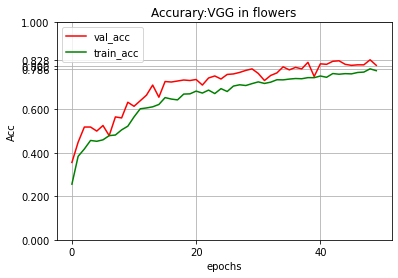

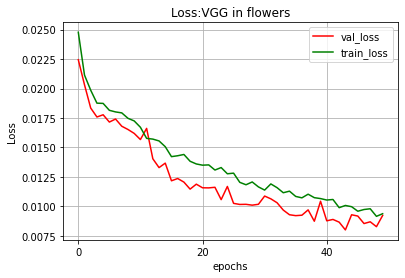

In [8]:
main()